In [ ]:
# import the code from ./lib.factorization
# first uncompress it from ./lib.zip
#!unzip -o lib.zip
import sys
sys.path.append('../../')
from lib.factorization import *
# ============================================
# Setup
# ============================================
import torch, torchvision, time, pandas as pd
import numpy as np
device = torch.device("cpu")  # torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print("Using device:", device)

#torch.backends.cudnn.benchmark = True
channels_last = True   # change to False if model doesn’t support it
use_amp = False    # set True for autocast (FP16) on CUDA

dtype = torch.float16 if use_amp and device.type == "cuda" else torch.float32
memory_format = torch.channels_last if channels_last else torch.contiguous_format

from lib.utils.layer_fusion import (
    fuse_batch_norm_inference,
    fuse_conv_bn,
    get_conv_bn_fuse_pairs,
)

# ============================================
# Model A: torchvision ResNet50
# ============================================
from torchvision.models import resnet50, ResNet50_Weights
model_a = resnet50(weights=ResNet50_Weights.DEFAULT).to(device).eval()
fuse_pairs = get_conv_bn_fuse_pairs(model_a)
model_a = fuse_conv_bn(
    model_a, fuse_pairs, fuse_impl=fuse_batch_norm_inference, inplace=False
)

#torch.compile(model_a)
#model_a = model_a.to(memory_format=torch.channels_last)
if channels_last:
    model_a = model_a.to(memory_format=torch.channels_last)

print("Model A ready (ResNet50).")

# ============================================
# Model B: load with torch.load from project root
# ============================================
model_b_path = "../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto/model_resnet50_ratio_0.500000.pth"
print("Loading Model B from:", model_b_path)
model_b = torch.load(model_b_path, map_location=device, weights_only=False)
if hasattr(model_b, "to"):
    model_b = model_b.to(device)
model_b = fuse_conv_bn(
    model_b, fuse_pairs, fuse_impl=fuse_batch_norm_inference, inplace=False
)
#print(model_b)
model_b.eval()
if channels_last and hasattr(model_b, "to"):
    try:
        model_b = model_b.to(memory_format=torch.channels_last)
    except Exception:
        pass
print("Model B ready.")

# ============================================
# Benchmark helper
# ============================================
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()


def run_benchmark(model, batch_sizes=(1, 8, 16, 32), iters=5, warmup=1):
    results = []
    for bs in batch_sizes:
        x = torch.randn(bs, 3, 224, 224, device=device, dtype=dtype)
        if memory_format == torch.channels_last:
            x = x.to(memory_format=torch.channels_last)

        # Warmup (not timed)
        for _ in range(warmup):
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else:
                _ = model(x)
        _sync()

        # Timed runs: sync EACH batch
        times_ms = []
        if device.type == "cuda":
            start = time.perf_counter()
            for _ in range(iters):
                

                if use_amp:
                    with torch.autocast(device_type="cuda", dtype=torch.float16):
                        _ = model(x)
                else:
                    _ = model(x)
            _sync()   
            times_ms.append((time.perf_counter() - start) * 1000.0)
                
        else:
            for _ in range(iters):
                t0 = time.perf_counter()
                _ = model(x)
                _sync()  # ensure completion for THIS batch
                dt_ms = (time.perf_counter() - t0) * 1000.0
                times_ms.append(dt_ms)

        # Stats
        avg_batch_ms = float(np.mean(times_ms))
        p50_ms = float(np.median(times_ms))
        p90_ms = float(np.percentile(times_ms, 90))
        ips = bs / (avg_batch_ms / 1000.0)  # throughput from avg per-batch time

        results.append({
            "batch_size": bs,
            "avg_batch_time_ms": avg_batch_ms,
            "p50_batch_time_ms": p50_ms,
            "p90_batch_time_ms": p90_ms,
            "images_per_sec": ips,
        })

    return pd.DataFrame(results)


# ============================================
# Run benchmarks
# ============================================

print("Benchmarking Model B...")
res_b = run_benchmark(model_b)


print("Benchmarking Model A (ResNet50)...")
res_a = run_benchmark(model_a)



df = res_a.merge(res_b, on="batch_size", suffixes=("_resnet50", "_modelB"))
df["speedup_vs_resnet50 (throughput)"] = df["images_per_sec_modelB"] / df["images_per_sec_resnet50"]
df["latency_ratio_modelB/resnet50"] = df["avg_batch_time_ms_modelB"] / df["avg_batch_time_ms_resnet50"]

print(df)

Using device: cpu
Model A ready (ResNet50).
Loading Model B from: ../../results/imagenet/resnet50/factorized_posttrain/flops_auto/flops_auto/model_resnet50_ratio_0.500000.pth
Model B ready.
Benchmarking Model B...
Benchmarking Model A (ResNet50)...


In [8]:
# import the code from ./lib.factorization
# first uncompress it from ./lib.zip
#!unzip -o lib.zip
import sys
sys.path.append('../../')
from lib.factorization import *

# ============================================
# Setup
# ============================================
import torch, torchvision, time, pandas as pd
import numpy as np
import timm

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print("Using device:", device)

#torch.backends.cudnn.benchmark = True
channels_last = False  # change to False if model doesn’t support it
use_amp = False    # set True for autocast (FP16) on CUDA

dtype = torch.float16 if use_amp and device.type == "cuda" else torch.float32
memory_format = torch.channels_last if channels_last else torch.contiguous_format

from lib.utils.layer_fusion import (
    fuse_batch_norm_inference,
    fuse_conv_bn,
    get_conv_bn_fuse_pairs,
)

# ============================================
# Model A: timm ViT-B/16
# ============================================
print("Loading Model A (timm ViT-B/16 pretrained)...")
model_a_vit = timm.create_model("vit_base_patch16_224", pretrained=True).to(device).eval()
fuse_pairs_vit = get_conv_bn_fuse_pairs(model_a_vit)


#torch.compile(model_a_vit)
#model_a_vit = model_a_vit.to(memory_format=torch.channels_last)
if channels_last:
    try:
        model_a_vit = model_a_vit.to(memory_format=torch.channels_last)
    except Exception:
        pass

print("Model A ready (ViT-B/16 timm).")

# ============================================
# Model B: load ViT with torch.load from project root
# ============================================
model_b_vit_path = "../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto/model_vit_b_16_ratio_0.600000.pth"
print("Loading Model B from:", model_b_vit_path)
model_b_vit = torch.load(model_b_vit_path, map_location=device, weights_only=False)
if hasattr(model_b_vit, "to"):
    model_b_vit = model_b_vit.to(device)

# print(model_b_vit)
model_b_vit.eval()
if channels_last and hasattr(model_b_vit, "to"):
    try:
        model_b_vit = model_b_vit.to(memory_format=torch.channels_last)
    except Exception:
        pass
print("Model B ready (loaded ViT).")

# ============================================
# Benchmark helper
# ============================================
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()


def run_benchmark(model, batch_sizes=(1, 8, 16, 32), iters=5, warmup=1):
    results = []
    for bs in batch_sizes:
        x = torch.randn(bs, 3, 224, 224, device=device, dtype=dtype)
        if memory_format == torch.channels_last:
            x = x.to(memory_format=torch.channels_last)

        # Warmup (not timed)
        for _ in range(warmup):
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else:
                _ = model(x)
            _sync()

        # Timed runs: sync EACH batch
        times_ms = []
        if device.type == "cuda":
            start = time.perf_counter()
            for _ in range(iters):
                if use_amp:
                    with torch.autocast(device_type="cuda", dtype=torch.float16):
                        _ = model(x)
                else:
                    _ = model(x)
                _sync()
            times_ms.append((time.perf_counter() - start) * 1000.0)
        else:
            for _ in range(iters):
                t0 = time.perf_counter()
                _ = model(x)
                _sync()  # ensure completion for THIS batch
                dt_ms = (time.perf_counter() - t0) * 1000.0
                times_ms.append(dt_ms)

        # Stats
        avg_batch_ms = float(np.mean(times_ms))
        p50_ms = float(np.median(times_ms))
        p90_ms = float(np.percentile(times_ms, 90))
        ips = bs / (avg_batch_ms / 1000.0)  # throughput from avg per-batch time

        results.append({
            "batch_size": bs,
            "avg_batch_time_ms": avg_batch_ms,
            "p50_batch_time_ms": p50_ms,
            "p90_batch_time_ms": p90_ms,
            "images_per_sec": ips,
        })

    return pd.DataFrame(results)

# ============================================
# Run benchmarks
# ============================================

print("Benchmarking Model B (loaded ViT)...")
res_b_vit = run_benchmark(model_b_vit)

print("Benchmarking Model A (timm ViT-B/16)...")
res_a_vit = run_benchmark(model_a_vit)

df_vit = res_a_vit.merge(res_b_vit, on="batch_size", suffixes=("_vit_timm", "_vit_loaded"))
df_vit["speedup_vs_timm_vit (throughput)"] = df_vit["images_per_sec_vit_loaded"] / df_vit["images_per_sec_vit_timm"]
df_vit["latency_ratio_loaded/timm"] = df_vit["avg_batch_time_ms_vit_loaded"] / df_vit["avg_batch_time_ms_vit_timm"]

print(df_vit)


Using device: cuda
Loading Model A (timm ViT-B/16 pretrained)...
Model A ready (ViT-B/16 timm).
Loading Model B from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto/model_vit_b_16_ratio_0.600000.pth
Model B ready (loaded ViT).
Benchmarking Model B (loaded ViT)...
Benchmarking Model A (timm ViT-B/16)...
   batch_size  avg_batch_time_ms_vit_timm  p50_batch_time_ms_vit_timm  \
0           1                     61.2511                     61.2511   
1           8                    373.3704                    373.3704   
2          16                    724.0091                    724.0091   
3          32                   1396.4475                   1396.4475   

   p90_batch_time_ms_vit_timm  images_per_sec_vit_timm  \
0                     61.2511                16.326237   
1                    373.3704                21.426444   
2                    724.0091                22.099170   
3                   1396.4475                22.915290   

   avg_batc

In [1]:
# import the code from ./lib.factorization
# first uncompress it from ./lib.zip
#!unzip -o lib.zip
import sys, os
sys.path.append('../../')
from lib.factorization import *

# ============================================
# Setup
# ============================================
import torch, time, pandas as pd, numpy as np, timm, matplotlib.pyplot as plt

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

channels_last = False  
use_amp = False        

dtype = torch.float16 if use_amp and device.type == "cuda" else torch.float32
memory_format = torch.channels_last if channels_last else torch.contiguous_format

from lib.utils.layer_fusion import get_conv_bn_fuse_pairs

# ============================================
# Config
# ============================================
BATCH_SIZES = (8, 16, 32)  
OUTPUT_PDF = "../../results/imagenet/plots/speedup_vit.pdf"

os.makedirs(os.path.dirname(OUTPUT_PDF), exist_ok=True)

# ============================================
# Baseline model (timm ViT-B/16)
# ============================================
print("Loading Model A (timm ViT-B/16 pretrained)...")
model_a_vit = timm.create_model("vit_base_patch16_224", pretrained=True).to(device).eval()
_ = get_conv_bn_fuse_pairs(model_a_vit)

if channels_last:
    try: model_a_vit = model_a_vit.to(memory_format=torch.channels_last)
    except Exception: pass
print("Model A ready (ViT-B/16 timm).")

# ============================================
# Benchmark helper
# ============================================
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def run_benchmark(model, batch_sizes=BATCH_SIZES, iters=5, warmup=1):
    results = []
    for bs in batch_sizes:
        x = torch.randn(bs, 3, 224, 224, device=device, dtype=dtype)
        if memory_format == torch.channels_last:
            x = x.to(memory_format=torch.channels_last)

        # Warmup
        for _ in range(warmup):
            if use_amp and device.type == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch.float16):
                    _ = model(x)
            else: _ = model(x)
            _sync()

        times_ms = []
        if device.type == "cuda":
            start = time.perf_counter()
            for _ in range(iters):
                if use_amp:
                    with torch.autocast(device_type="cuda", dtype=torch.float16):
                        _ = model(x)
                else: _ = model(x)
                _sync()
            times_ms.append((time.perf_counter() - start) * 1000.0)
        else:
            for _ in range(iters):
                t0 = time.perf_counter()
                _ = model(x); _sync()
                times_ms.append((time.perf_counter() - t0) * 1000.0)

        avg_batch_ms = float(np.mean(times_ms))
        ips = bs / (avg_batch_ms / 1000.0)

        results.append({"batch_size": bs, "avg_batch_time_ms": avg_batch_ms, "images_per_sec": ips})
    return pd.DataFrame(results)

# baseline benchmark
print("Benchmarking baseline (timm ViT-B/16)...")
res_baseline = run_benchmark(model_a_vit)
res_baseline = res_baseline.rename(columns={
    "avg_batch_time_ms": "avg_batch_time_ms_vit_timm",
    "images_per_sec": "images_per_sec_vit_timm",
})

# ============================================
# Model B variants
# ============================================
ratios = [0.3, 0.5, 0.6, 0.7, 0.85]
base_path = "../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto"

def load_model_b(ratio: float):
    path = os.path.join(base_path, f"model_vit_b_16_ratio_{ratio:.6f}.pth")
    print(f"\nLoading Model B (ratio={ratio}) from: {path}")
    if not os.path.exists(path):
        print("  -> SKIP: file not found")
        return None
    mb = torch.load(path, map_location=device, weights_only=False)
    if hasattr(mb, "to"):
        mb = mb.to(device).eval()
        if channels_last:
            try: mb = mb.to(memory_format=torch.channels_last)
            except Exception: pass
    print("Model B ready.")
    return mb

detailed_rows = []

for r in ratios:
    model_b = load_model_b(r)
    if model_b is None: continue

    print(f"Benchmarking Model B @ ratio={r} ...")
    res_b = run_benchmark(model_b)
    res_b = res_b.rename(columns={
        "avg_batch_time_ms": "avg_batch_time_ms_vit_loaded",
        "images_per_sec": "images_per_sec_vit_loaded",
    })

    df = res_baseline.merge(res_b, on="batch_size", how="inner")
    df["speedup_vs_timm_vit"] = df["images_per_sec_vit_loaded"] / df["images_per_sec_vit_timm"]
    df["ratio"] = r
    detailed_rows.append(df)

# ============================================
# Results summary + plot
# ============================================
if not detailed_rows:
    raise RuntimeError("No checkpoints found; nothing to plot.")

detailed_df = pd.concat(detailed_rows, ignore_index=True)
print("\n=== Detailed results ===")
print(detailed_df[["ratio","batch_size","images_per_sec_vit_timm",
                   "images_per_sec_vit_loaded","speedup_vs_timm_vit"]]
      .sort_values(["batch_size","ratio"]).to_string(index=False))





A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Us

AttributeError: _ARRAY_API not found

c:\Users\dagom\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading Model A (timm ViT-B/16 pretrained)...
Model A ready (ViT-B/16 timm).
Benchmarking baseline (timm ViT-B/16)...

Loading Model B (ratio=0.3) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.300000.pth
Model B ready.
Benchmarking Model B @ ratio=0.3 ...

Loading Model B (ratio=0.5) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.500000.pth
Model B ready.
Benchmarking Model B @ ratio=0.5 ...

Loading Model B (ratio=0.6) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.600000.pth
Model B ready.
Benchmarking Model B @ ratio=0.6 ...

Loading Model B (ratio=0.7) from: ../../results/imagenet/vit_b_16/factorized_posttrain/flops_auto/flops_auto\model_vit_b_16_ratio_0.700000.pth
Model B ready.
Benchmarking Model B @ ratio=0.7 ...

Loading Model B (ratio=0.85) from: ../../results/imagenet/vit_b_16/factorized_


Saved plot to: ../../results/imagenet/plots/speedup_vit.pdf


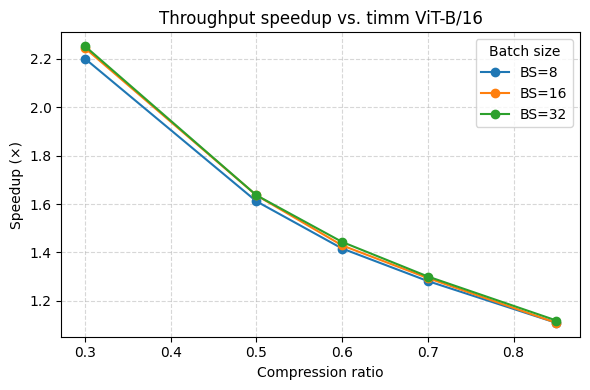

In [2]:
# plot: one line per batch size
plt.figure(figsize=(6, 4))
for bs in BATCH_SIZES:
    sub = detailed_df[detailed_df["batch_size"] == bs].sort_values("ratio")
    plt.plot(sub["ratio"], sub["speedup_vs_timm_vit"], marker="o", label=f"BS={bs}")

plt.title("Throughput speedup vs. timm ViT-B/16")
plt.xlabel("Compression ratio")
plt.ylabel("Speedup (×)")
plt.legend(title="Batch size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, format="pdf", bbox_inches="tight")
print(f"\nSaved plot to: {OUTPUT_PDF}")
plt.show()  # enable if running interactively